In [ ]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot





VISUALIZACIÓN DE DATOS


Text(0, 0.5, 'Dow Jones Index Data Set')

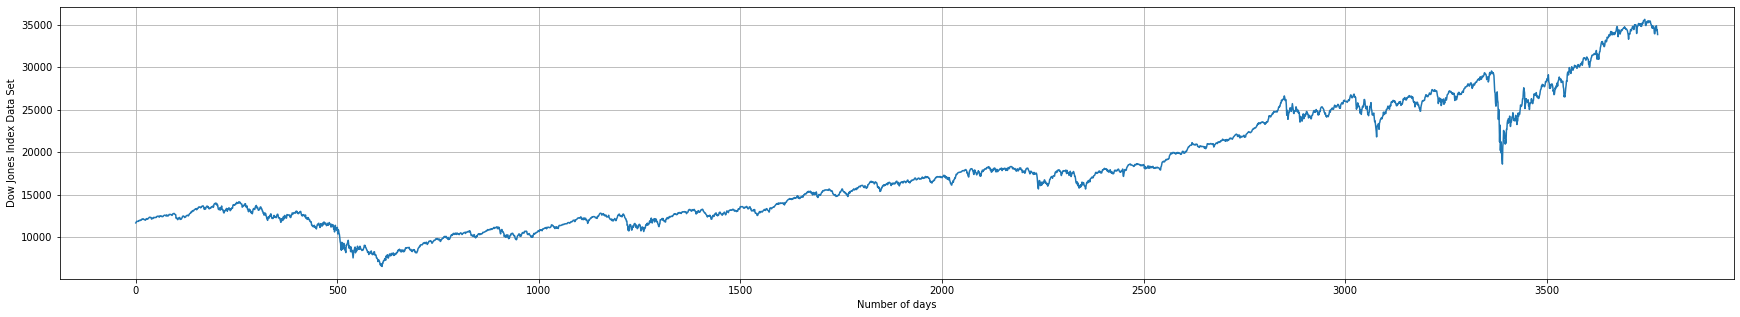

In [ ]:
complete_dataframe = pd.read_csv('dataset.csv')
complete_dataframe = complete_dataframe.sort_index(ascending=True)
plt.figure(figsize=(30,5))
plt.plot(complete_dataframe.index.values, complete_dataframe.DJI.values)
plt.grid();
plt.xlabel("Number of days")
plt.ylabel("Dow Jones Index Data Set")

MÉTODO PARA PREPARAR LOS DATOS


In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [ ]:
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

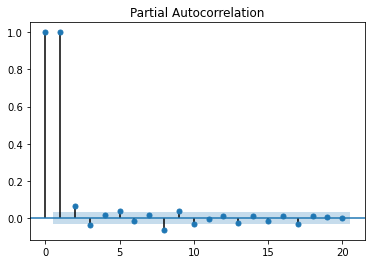

In [78]:
from statsmodels.graphics.tsaplots import plot_pacf
datasetO = pd.read_csv('dataset.csv', usecols=[1], engine='python', skipfooter=3)
plot_pacf(datasetO, lags=20)
plt.show()

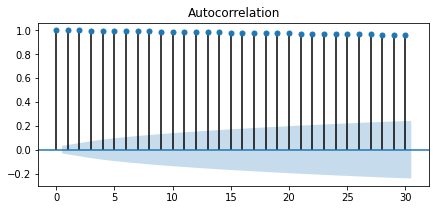

In [152]:
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(datasetO, ax=ax, lags=30)
plt.show()

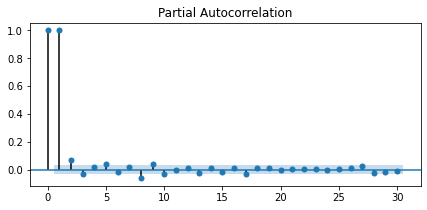

In [86]:
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(datasetO, ax=ax, lags=30)
plt.show()

RANDOM FOREST

In [130]:
from sklearn.ensemble import RandomForestRegressor


In [131]:
def walk_forward_randomforest(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, 1], predictions

In [132]:
# fit an random_forest_forecast and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


MAE: 264.781


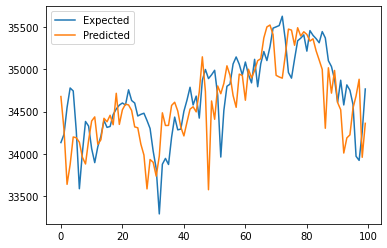

In [133]:
# load the dataset
series = read_csv('dataset.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_randomforest(data, 100)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

Redes neuronales artificiales, LSTM 

In [134]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [135]:
numpy.random.seed(7)

In [136]:
dataframe = pandas.read_csv('dataset.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [137]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


In [138]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [139]:
look_back = 14
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [140]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [142]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['accuracy'])
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
2514/2514 - 5s - loss: 0.0137 - accuracy: 3.9777e-04
Epoch 2/100
2514/2514 - 3s - loss: 0.0080 - accuracy: 3.9777e-04
Epoch 3/100
2514/2514 - 3s - loss: 0.0076 - accuracy: 3.9777e-04
Epoch 4/100
2514/2514 - 3s - loss: 0.0072 - accuracy: 3.9777e-04
Epoch 5/100
2514/2514 - 3s - loss: 0.0068 - accuracy: 3.9777e-04
Epoch 6/100
2514/2514 - 3s - loss: 0.0067 - accuracy: 3.9777e-04
Epoch 7/100
2514/2514 - 3s - loss: 0.0063 - accuracy: 3.9777e-04
Epoch 8/100
2514/2514 - 3s - loss: 0.0060 - accuracy: 3.9777e-04
Epoch 9/100
2514/2514 - 3s - loss: 0.0061 - accuracy: 3.9777e-04
Epoch 10/100
2514/2514 - 3s - loss: 0.0058 - accuracy: 3.9777e-04
Epoch 11/100
2514/2514 - 3s - loss: 0.0057 - accuracy: 3.9777e-04
Epoch 12/100
2514/2514 - 3s - loss: 0.0056 - accuracy: 3.9777e-04
Epoch 13/100
2514/2514 - 3s - loss: 0.0054 - accuracy: 3.9777e-04
Epoch 14/100
2514/2514 - 3s - loss: 0.0054 - accuracy: 3.9777e-04
Epoch 15/100
2514/2514 - 3s - loss: 0.0053 - accuracy: 3.9777e-04
Epoch 16/100
2514/2

In [143]:
scores = model.evaluate(trainX, trainY, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 0.04%


In [144]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MAE' % (trainScore))
testScore = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MAE' % (testScore))

Train Score: 145.94 MAE
Test Score: 2211.02 MAE


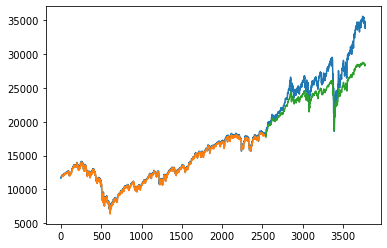

In [145]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

XGBoost 

In [61]:
import xgboost as xgb
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from numpy import asarray
from matplotlib import pyplot



In [146]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]

In [147]:
# walk-forward validation for univariate data
def walk_forward_validation_xgboost(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


>expected=34269.2, predicted=34676.7
>expected=33587.7, predicted=34285.8
>expected=34021.4, predicted=33639.5
>expected=34382.1, predicted=33873.6
>expected=34327.8, predicted=34198.9
>expected=34060.7, predicted=34190.0
>expected=33896.0, predicted=34136.9
>expected=34084.2, predicted=33958.7
>expected=34207.8, predicted=33880.2
>expected=34394.0, predicted=34158.0
>expected=34312.5, predicted=34387.9
>expected=34323.1, predicted=34436.3
>expected=34464.6, predicted=34112.5
>expected=34529.4, predicted=34166.2
>expected=34575.3, predicted=34419.5
>expected=34600.4, predicted=34378.6
>expected=34577.0, predicted=34455.4
>expected=34756.4, predicted=34343.5
>expected=34630.2, predicted=34715.1
>expected=34599.8, predicted=34347.8
>expected=34447.1, predicted=34520.6
>expected=34466.2, predicted=34586.5
>expected=34479.6, predicted=34577.7
>expected=34393.8, predicted=34512.4
>expected=34299.3, predicted=34318.6
>expected=34033.7, predicted=34307.5
>expected=33823.4, predicted=34114.2
>

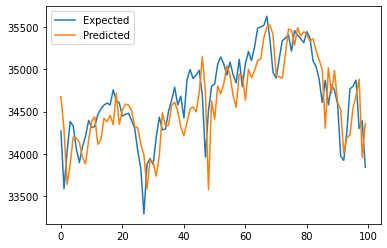

In [148]:
series = read_csv('dataset.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation_xgboost(data, 100)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [ ]:
Regresión Múltiple

In [69]:
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error

In [149]:
# fit an xgboost model and make a one step prediction
def linear_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = linear_model.LinearRegression()
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]

In [150]:
def walk_forward_validation_linear(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = linear_forecast(history,testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, 1], predictions

>expected=34269.2, predicted=34787.7
>expected=33587.7, predicted=34337.9
>expected=34021.4, predicted=33645.2
>expected=34382.1, predicted=33905.7
>expected=34327.8, predicted=34399.6
>expected=34060.7, predicted=34420.2
>expected=33896.0, predicted=34071.6
>expected=34084.2, predicted=33898.2
>expected=34207.8, predicted=34064.1
>expected=34394.0, predicted=34232.1
>expected=34312.5, predicted=34398.2
>expected=34323.1, predicted=34341.7
>expected=34464.6, predicted=34329.4
>expected=34529.4, predicted=34451.1
>expected=34575.3, predicted=34557.6
>expected=34600.4, predicted=34588.8
>expected=34577.0, predicted=34608.9
>expected=34756.4, predicted=34598.3
>expected=34630.2, predicted=34743.3
>expected=34599.8, predicted=34678.8
>expected=34447.1, predicted=34612.5
>expected=34466.2, predicted=34467.5
>expected=34479.6, predicted=34475.7
>expected=34393.8, predicted=34489.3
>expected=34299.3, predicted=34429.5
>expected=34033.7, predicted=34313.6
>expected=33823.4, predicted=34074.4
>

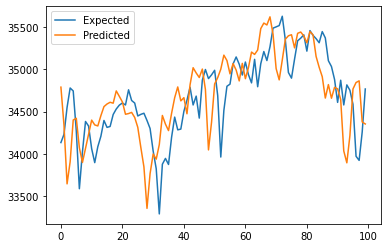

In [151]:
series = read_csv('dataset.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation_linear(data, 100)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

SVR

In [ ]:

from sklearn import svm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error
import math
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
numpy.random.seed(7)

In [ ]:
dataframe = pandas.read_csv('dataset.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [ ]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX

array([[[0.17618953, 0.17814939, 0.18238865]],

       [[0.17814939, 0.18238865, 0.18294163]],

       [[0.18238865, 0.18294163, 0.18237488]],

       ...,

       [[0.40213567, 0.4051808 , 0.3982898 ]],

       [[0.4051808 , 0.3982898 , 0.39882421]],

       [[0.3982898 , 0.39882421, 0.39726776]]], dtype=float32)

In [ ]:
svr_rbf = svm.SVR(kernel='rbf', C=1e2, gamma=0.1)
svr_rbf.fit(trainX,trainY)
p3 = svr_rbf.predict(testX)
    
error = mean_squared_error(y_test, p1)
print('RBF model Test MSE: %.3f' % error)
plt.plot(y_test, label='True Data')
plt.plot(p1, label='RBF model Predict')
plt.title('Support Vector Regression(RBF)')
plt.legend()
plt.show()
    
  


ValueError: ignored

PCA

Random forest

In [91]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

estimators_pca_rf = [('Dimension Reducer', PCA(n_components=0.90,random_state=1)), ('Classifier', RandomForestRegressor(max_depth=39))]
pipeline_pca_rf = Pipeline(estimators_pca_rf)
pipeline_pca_rf

Pipeline(memory=None,
         steps=[('Dimension Reducer',
                 PCA(copy=True, iterated_power='auto', n_components=0.9,
                     random_state=1, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('Classifier',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=39,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=None,
                                

In [125]:
dataframe = pandas.read_csv('dataset.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [126]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [127]:
look_back = 14
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [128]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [129]:
pipeline_pca_rf.fit(trainX,trainY);

ValueError: ignored

In [124]:
# make predictions
trainPredict = pipeline_pca_rf.predict(trainX)
testPredict = pipeline_pca_rf.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

ValueError: ignored